In [105]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets
from collections import defaultdict

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [106]:
artifacts_dir = "/etc/skel/sandmark-nightly/sequential/"

In [107]:
bench_files = []

artifacts_path = artifacts_dir.split("/sequential/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orun.summary.bench"):
            f = root.split("/sequential/")
            bench_files.append((os.path.join(root, file)))

In [108]:
for b in bench_files :
    print(b + '\n')

/home/sk/sandmark-nightly/sequential/20210608_084403/7e6b22b232146f9177cbfa874b3fcc66ceed192b/4.12.0+stock_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210608_084403/06d5aa0bf63778de509a7eee129bb5f31508466f/4.12.0+domains+effects_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210608_141854/7e6b22b232146f9177cbfa874b3fcc66ceed192b/4.12.0+stock_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210608_141854/06d5aa0bf63778de509a7eee129bb5f31508466f/4.12.0+domains+effects_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210608_120547/7e6b22b232146f9177cbfa874b3fcc66ceed192b/4.12.0+stock_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210608_120547/06d5aa0bf63778de509a7eee129bb5f31508466f/4.12.0+domains+effects_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210609_000004/18c483d54de6fa7ec474521de01d319cb5dedd44/4.12.0+domains+effects_1.orun.summary.bench

/home/sk/sandmark-nightly/sequential/20210609_000004/7e6b

In [109]:
benches = defaultdict(list)
for x in bench_files:
    l = x.split("/sequential/")[1]
    d = l.split("/")
    timestamp    = d[0]
    commit       = d[1]
    variant      = d[2]
    variant_root = d[2].split('_')[0]
    variant_stem = d[2].split('_')[1]
    value        = variant_root + '+' + commit + '_' + variant_stem
    benches[timestamp].append(value)
benches = dict(benches)

In [110]:
benches

{'20210608_084403': ['4.12.0+stock+7e6b22b232146f9177cbfa874b3fcc66ceed192b_1.orun.summary.bench',
  '4.12.0+domains+effects+06d5aa0bf63778de509a7eee129bb5f31508466f_1.orun.summary.bench'],
 '20210608_141854': ['4.12.0+stock+7e6b22b232146f9177cbfa874b3fcc66ceed192b_1.orun.summary.bench',
  '4.12.0+domains+effects+06d5aa0bf63778de509a7eee129bb5f31508466f_1.orun.summary.bench'],
 '20210608_120547': ['4.12.0+stock+7e6b22b232146f9177cbfa874b3fcc66ceed192b_1.orun.summary.bench',
  '4.12.0+domains+effects+06d5aa0bf63778de509a7eee129bb5f31508466f_1.orun.summary.bench'],
 '20210609_000004': ['4.12.0+domains+effects+18c483d54de6fa7ec474521de01d319cb5dedd44_1.orun.summary.bench',
  '4.12.0+stock+7e6b22b232146f9177cbfa874b3fcc66ceed192b_1.orun.summary.bench']}

In [111]:
def f(x): return x

def disp(benches):
    
    def select_commit(timestamp):
        variantW.options = benches[timestamp]
    
    def do_nothing(variant):
        pass
    
    timestamp_list = sorted(list(benches.keys()), reverse=True)
    timestampW = widgets.Dropdown(options=timestamp_list, description='Timestamp', disabled=False)
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[timestampW.value], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    display(box)
    return (timestampD, variantD)

def get_filename(t, v):
    timestamp = t.children[0].value
    commit_id = v.children[0].value.split('_')[0].split('+')[-1]
    variant   = v.children[0].value.split('_')[0].split('+')
    variant.pop()
    variant   = '+'.join(variant) + '_' + v.children[0].value.split('_')[1]
    filename  = os.path.join(
        artifacts_path, 
        "sequential", 
        timestamp,
        commit_id,
        variant
        )
    print(filename)
    return filename

In [112]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [113]:
print(comparisons.result)

2


In [114]:
matrix = [[0 for x in range(3)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210609_000004', '20210608_14…

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210609_000004', '20210608_14…

In [115]:
for i in range(comparisons.result):
    matrix[i][2] = get_filename(matrix[i][0], matrix[i][1])

/home/sk/sandmark-nightly/sequential/20210609_000004/18c483d54de6fa7ec474521de01d319cb5dedd44/4.12.0+domains+effects_1.orun.summary.bench
/home/sk/sandmark-nightly/sequential/20210609_000004/18c483d54de6fa7ec474521de01d319cb5dedd44/4.12.0+domains+effects_1.orun.summary.bench


In [116]:
selected_files = []
for i in range (comparisons.result):
    print(matrix[i][2])
    selected_files.append(matrix[i][2])

/home/sk/sandmark-nightly/sequential/20210609_000004/18c483d54de6fa7ec474521de01d319cb5dedd44/4.12.0+domains+effects_1.orun.summary.bench
/home/sk/sandmark-nightly/sequential/20210609_000004/18c483d54de6fa7ec474521de01d319cb5dedd44/4.12.0+domains+effects_1.orun.summary.bench


In [117]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        value     = file.split('/sequential/')[1]
        date      = value.split('/')[0].split('_')[0]
        commit_id = value.split('/')[1][:7]
        variant   = value.split('/')[2].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)
df

<ipython-input-117-38af5c608848>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pdjson.json_normalize(data)


,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.186104,4.165800,0.020008,37948,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,4.12.0+domains+effects_20210609_18c483d
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.186104,4.165800,0.020008,37948,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,4.12.0+domains+effects_20210609_18c483d
24,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.464264,2.232233,0.231715,425840,2865106.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,168246834,43600283,60772349,653,17,0,51724355,52392003,5.562554,4.12.0+domains+effects_20210609_18c483d
24,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.464264,2.232233,0.231715,425840,2865106.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,168246834,43600283,60772349,653,17,0,51724355,52392003,5.562554,4.12.0+domains+effects_20210609_18c483d
13,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,18.345802,18.126034,0.219306,318912,2865106.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2044232431,54649006,83490702,7824,27,0,38256313,38256313,25.389450,4.12.0+domains+effects_20210609_18c483d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,thread_ring_lwt_stream.20_000,taskset --cpu-list 5 ./thread_ring_lwt_stream....,11.128879,11.128607,0.000000,10468,437221.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1821156682,362286608,362287934,9265,2317,0,505074,529650,117.394349,4.12.0+domains+effects_20210609_18c483d
5,yojson_ydump.sample.json,taskset --cpu-list 5 ./ydump.exe -c sample.json,0.774715,0.770490,0.003992,11724,542103.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,9737880,903683,3114459,53,18,0,464166,554730,117.244679,4.12.0+domains+effects_20210609_18c483d
5,yojson_ydump.sample.json,taskset --cpu-list 5 ./ydump.exe -c sample.json,0.774715,0.770490,0.003992,11724,542103.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,9737880,903683,3114459,53,18,0,464166,554730,117.244679,4.12.0+domains+effects_20210609_18c483d
40,zarith_pi.5000,taskset --cpu-list 5 ./zarith_pi.exe 5000,0.590468,0.574291,0.015952,17012,208857.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,3413372,10325,392714783,757,747,0,1116409,1393732,105.226066,4.12.0+domains+effects_20210609_18c483d


In [118]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.186104,4.165800,0.020008,37948,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,4.12.0+domains+effects_20210609_18c483d
11,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.186104,4.165800,0.020008,37948,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,2153773382,166,4194792,8217,2,0,4231434,4231434,3.492858,4.12.0+domains+effects_20210609_18c483d
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.523607,5.511275,0.011998,22352,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,4.12.0+domains+effects_20210609_18c483d
36,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.523607,5.511275,0.011998,22352,164078.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1227959520,1951995,2484415,4695,10,0,2023316,2088855,24.370582,4.12.0+domains+effects_20210609_18c483d
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.858793,11.790379,0.068013,146908,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,4.12.0+domains+effects_20210609_18c483d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,thread_ring_lwt_stream.20_000,taskset --cpu-list 5 ./thread_ring_lwt_stream....,11.128879,11.128607,0.000000,10468,437221.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,1821156682,362286608,362287934,9265,2317,0,505074,529650,117.394349,4.12.0+domains+effects_20210609_18c483d
5,yojson_ydump.sample.json,taskset --cpu-list 5 ./ydump.exe -c sample.json,0.774715,0.770490,0.003992,11724,542103.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,9737880,903683,3114459,53,18,0,464166,554730,117.244679,4.12.0+domains+effects_20210609_18c483d
5,yojson_ydump.sample.json,taskset --cpu-list 5 ./ydump.exe -c sample.json,0.774715,0.770490,0.003992,11724,542103.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,9737880,903683,3114459,53,18,0,464166,554730,117.244679,4.12.0+domains+effects_20210609_18c483d
40,zarith_pi.5000,taskset --cpu-list 5 ./zarith_pi.exe 5000,0.590468,0.574291,0.015952,17012,208857.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,3413372,10325,392714783,757,747,0,1116409,1393732,105.226066,4.12.0+domains+effects_20210609_18c483d


In [119]:
baseline_t, baseline_v = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210609_000004', '20210608_14…

In [120]:
selected_baseline = ""
date      = baseline_t.children[0].value.split('_')[0]
commit_id = baseline_v.children[0].value.split('_')[0].split('+')[-1][:7]
variant   = baseline_v.children[0].value.split('_')[0].split('+')
variant.pop()
variant   = "+".join(variant)
value     = variant + '_' + date + '_' + commit_id
selected_baseline = value

print(selected_baseline)

4.12.0+domains+effects_20210609_18c483d


In [121]:
df.loc[(df['variant'] == selected_baseline) & (df['time_secs'] > 10)]

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.858793,11.790379,0.068013,146908,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,4.12.0+domains+effects_20210609_18c483d
43,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,11.858793,11.790379,0.068013,146908,282776.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,916489945,280594226,280594544,3565,69,0,15786238,18084094,38.706226,4.12.0+domains+effects_20210609_18c483d
49,coq.AbstractInterpretation.v,taskset --cpu-list 5 coqc benchmarks/coq/Abstr...,325.020283,323.754680,1.263994,1181944,5910732.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,71170254246,660526519,975009405,271639,79,0,66611650,118553756,44.585576,4.12.0+domains+effects_20210609_18c483d
49,coq.AbstractInterpretation.v,taskset --cpu-list 5 coqc benchmarks/coq/Abstr...,325.020283,323.754680,1.263994,1181944,5910732.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,71170254246,660526519,975009405,271639,79,0,66611650,118553756,44.585576,4.12.0+domains+effects_20210609_18c483d
7,coq.BasicSyntax.v,taskset --cpu-list 5 coqc benchmarks/coq/Basic...,113.459703,112.934450,0.523992,666780,5910732.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,23594665483,328328150,341550110,90113,42,0,53848615,56151196,37.258472,4.12.0+domains+effects_20210609_18c483d
7,coq.BasicSyntax.v,taskset --cpu-list 5 coqc benchmarks/coq/Basic...,113.459703,112.934450,0.523992,666780,5910732.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,23594665483,328328150,341550110,90113,42,0,53848615,56151196,37.258472,4.12.0+domains+effects_20210609_18c483d
39,cpdf.scale,taskset --cpu-list 5 cpdf scale-to-fit a4lands...,14.051813,13.847367,0.203990,288196,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,592505902,85185522,95775244,2286,28,0,33343919,34731704,27.234306,4.12.0+domains+effects_20210609_18c483d
39,cpdf.scale,taskset --cpu-list 5 cpdf scale-to-fit a4lands...,14.051813,13.847367,0.203990,288196,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,592505902,85185522,95775244,2286,28,0,33343919,34731704,27.234306,4.12.0+domains+effects_20210609_18c483d
45,cpdf.squeeze,taskset --cpu-list 5 cpdf -squeeze benchmarks/...,16.307168,16.066734,0.239981,372240,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,422126124,124455393,140126340,1655,32,0,29010811,45884648,28.547347,4.12.0+domains+effects_20210609_18c483d
45,cpdf.squeeze,taskset --cpu-list 5 cpdf -squeeze benchmarks/...,16.307168,16.066734,0.239981,372240,1139519.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,422126124,124455393,140126340,1655,32,0,29010811,45884648,28.547347,4.12.0+domains+effects_20210609_18c483d


In [122]:
df.filter(['name','variant','time_secs'])

,name,variant,time_secs
11,LU_decomposition.1024,4.12.0+domains+effects_20210609_18c483d,4.186104
11,LU_decomposition.1024,4.12.0+domains+effects_20210609_18c483d,4.186104
36,bdd.26,4.12.0+domains+effects_20210609_18c483d,5.523607
36,bdd.26,4.12.0+domains+effects_20210609_18c483d,5.523607
43,binarytrees5.21,4.12.0+domains+effects_20210609_18c483d,11.858793
...,...,...,...
22,thread_ring_lwt_stream.20_000,4.12.0+domains+effects_20210609_18c483d,11.128879
5,yojson_ydump.sample.json,4.12.0+domains+effects_20210609_18c483d,0.774715
5,yojson_ydump.sample.json,4.12.0+domains+effects_20210609_18c483d,0.774715
40,zarith_pi.5000,4.12.0+domains+effects_20210609_18c483d,0.590468


## Time

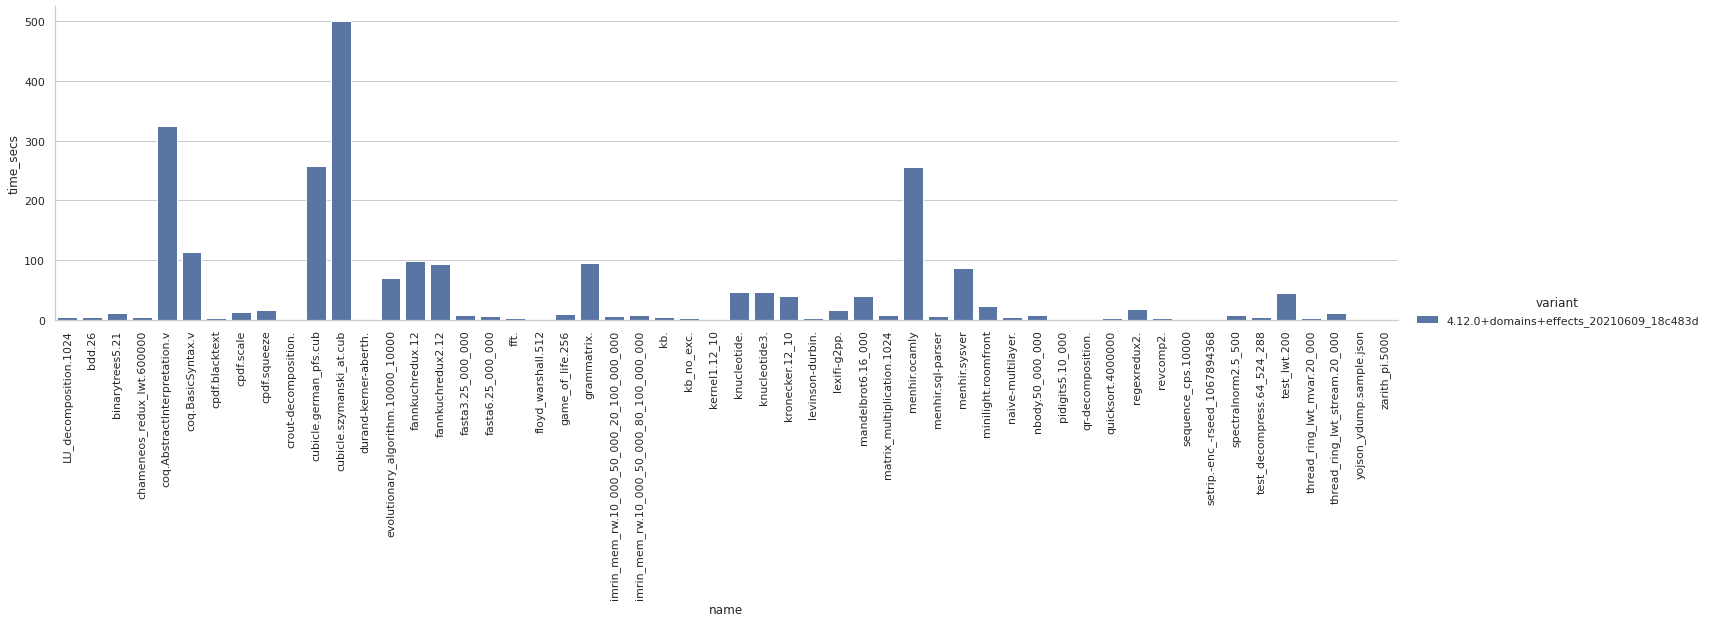

In [123]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalized

In [124]:
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name'])
            for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
            df = pd.concat(ndata_frames)
            return df
        else:
            print("The selected baseline variant is equal to the other variants\n" 
                  + "Update the dropdowns with different varians to plot normalisation graphs\n")
            return None

def plot_normalised(df,variant,topic):
    if df is not None:
        df = pd.DataFrame.copy(df)
        df.sort_values(by=[topic],inplace=True)
        df[topic] = df[topic] - 1
        g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
        g.set_xticklabels(rotation=90)
        g.ax.legend(loc=8)
        g._legend.remove()
        g.ax.set_xlabel("Benchmarks")
        return g
        # g.ax.set_yscale('log')
    else:
        print("ndf is equal to None, possibly due to variants being equal to the baseline variant\n")

In [125]:

ndf = normalise(df, selected_baseline,'time_secs')
plot_normalised(ndf, selected_baseline,'ntime_secs')

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


## Top heap words

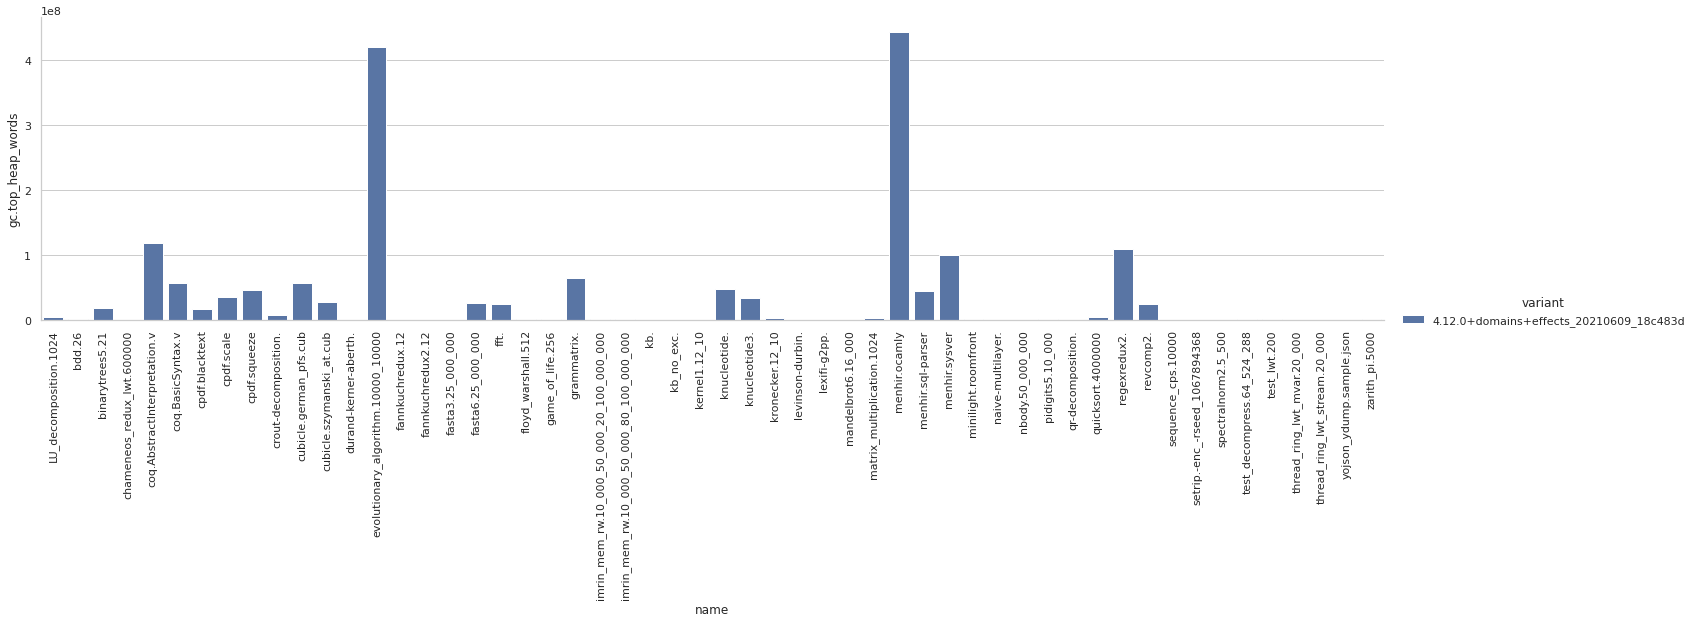

In [126]:
g = sns.catplot (x='name', y='gc.top_heap_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [127]:
ndf = normalise(df,selected_baseline,'gc.top_heap_words')
plot_normalised(ndf,selected_baseline,'ngc.top_heap_words')

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


## Max RSS (KB)

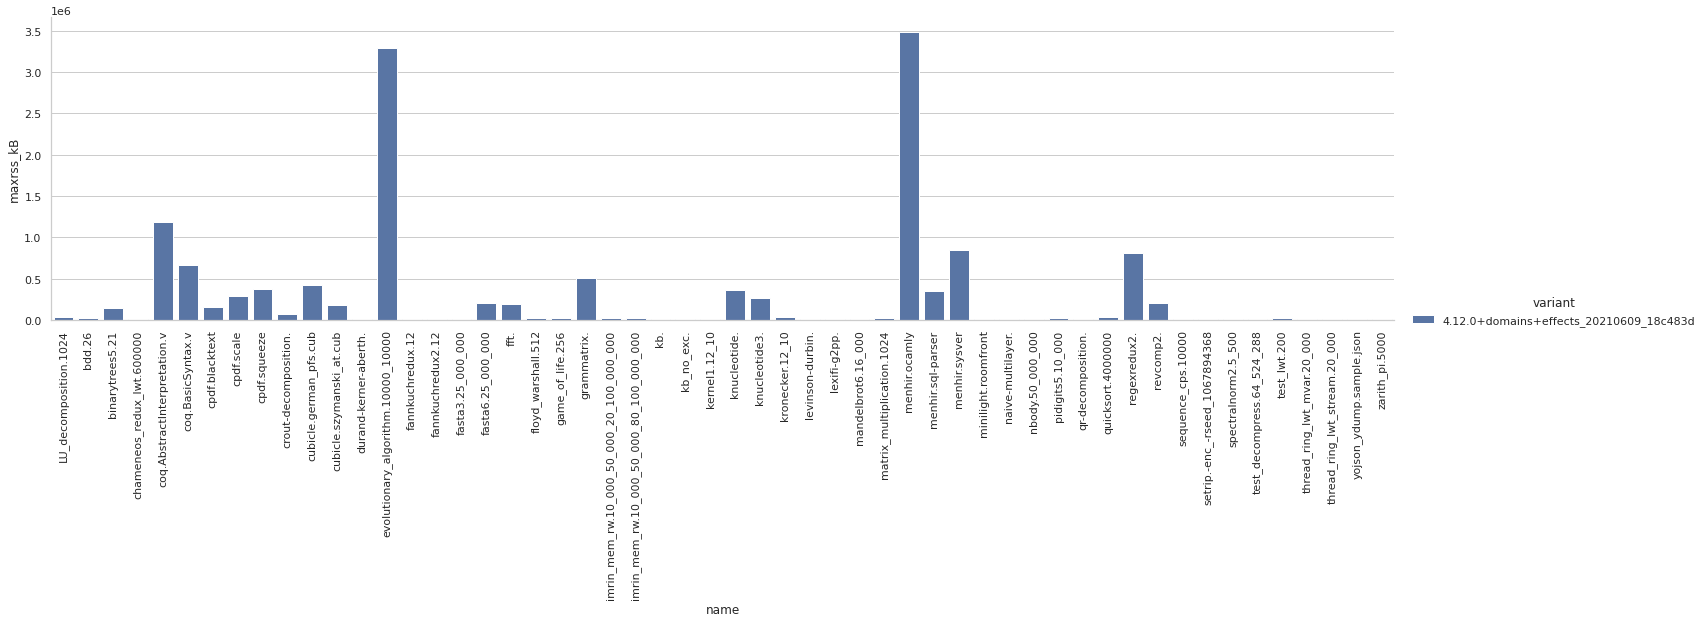

In [128]:
g = sns.catplot (x='name', y='maxrss_kB', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [129]:
ndf = normalise(df,selected_baseline,'maxrss_kB')
plot_normalised(ndf,selected_baseline,'nmaxrss_kB')

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


## Major Collections

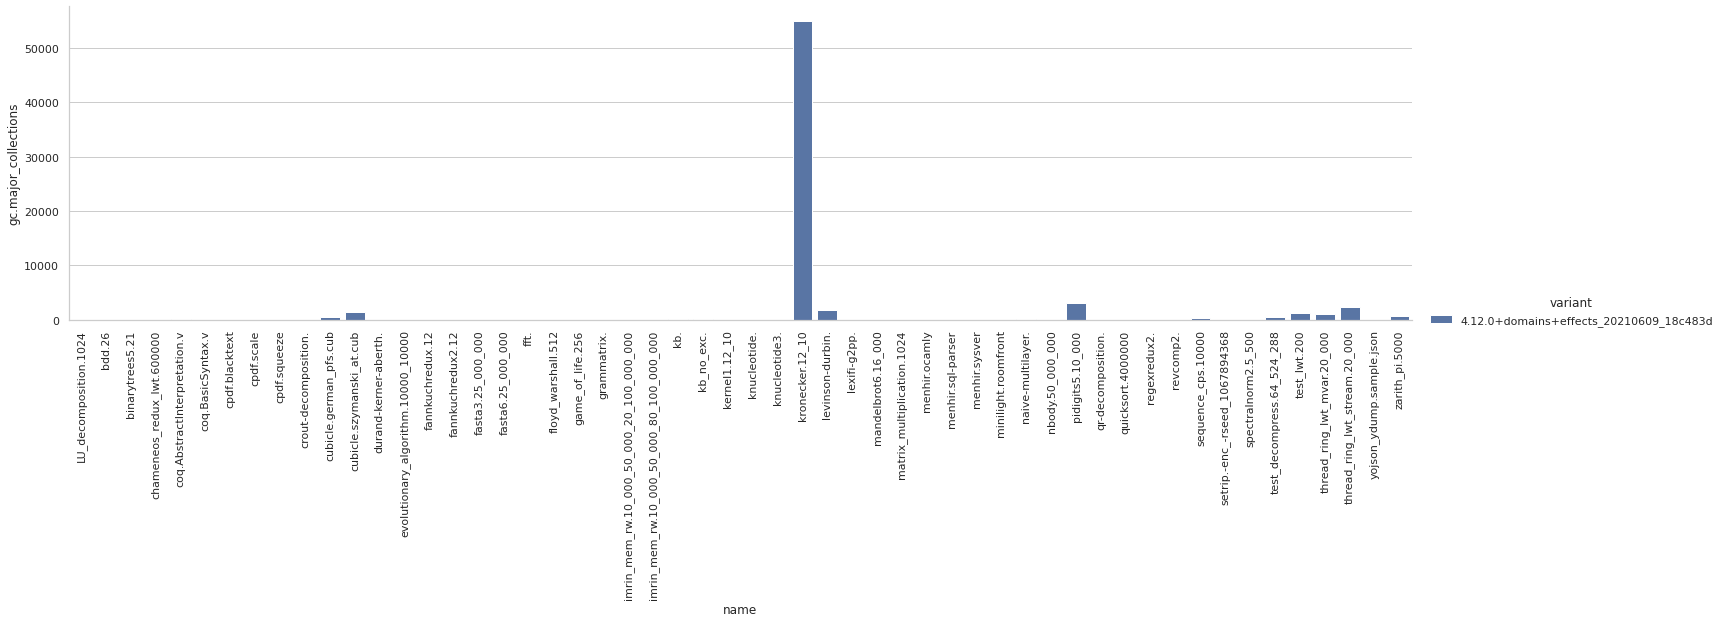

In [130]:
g = sns.catplot (x='name', y='gc.major_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [131]:
ndf = normalise(df,selected_baseline,'gc.major_collections')
plot_normalised(ndf,selected_baseline,'ngc.major_collections')
ndf

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


## Major words

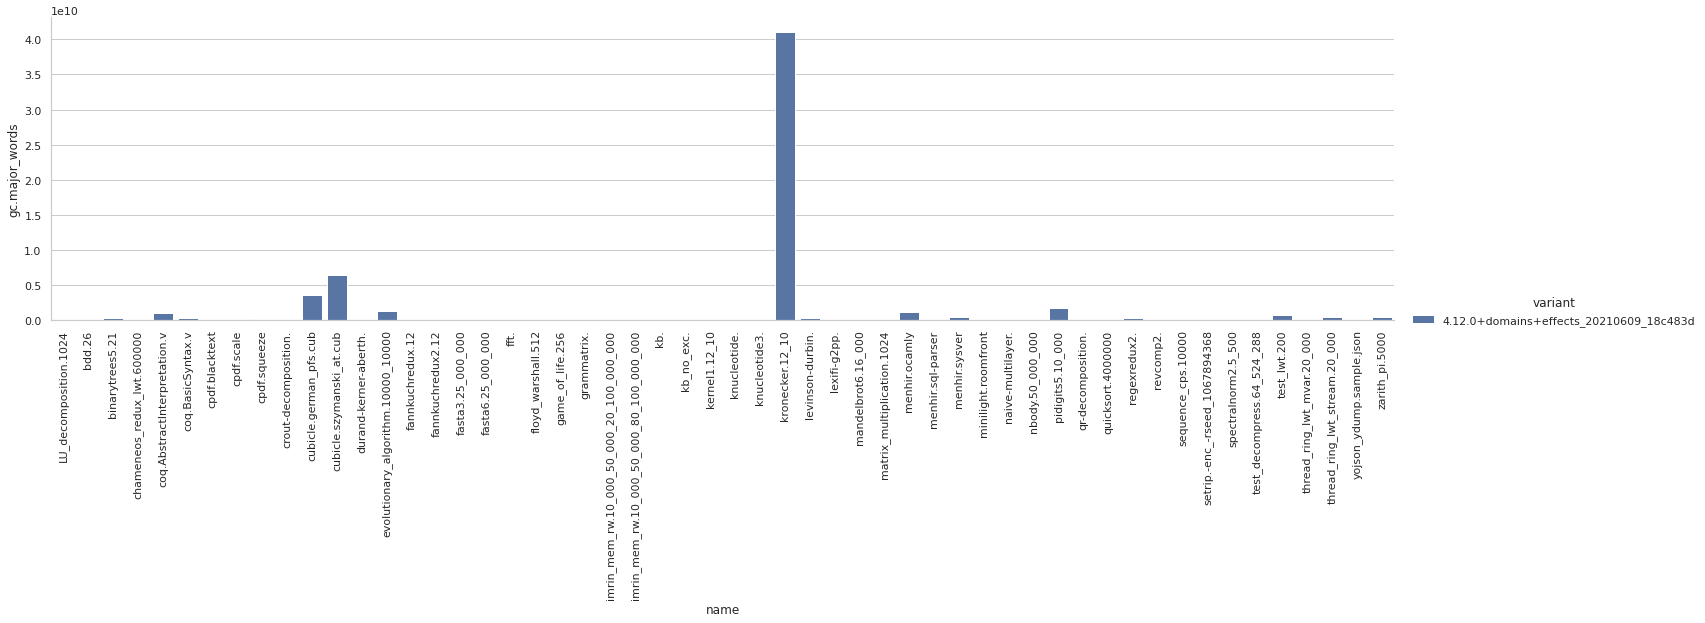

In [132]:
g = sns.catplot (x='name', y='gc.major_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [133]:
ndf = normalise(df,selected_baseline,'gc.major_words')
plot_normalised(ndf,selected_baseline,'ngc.major_words')

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


## Minor Collections

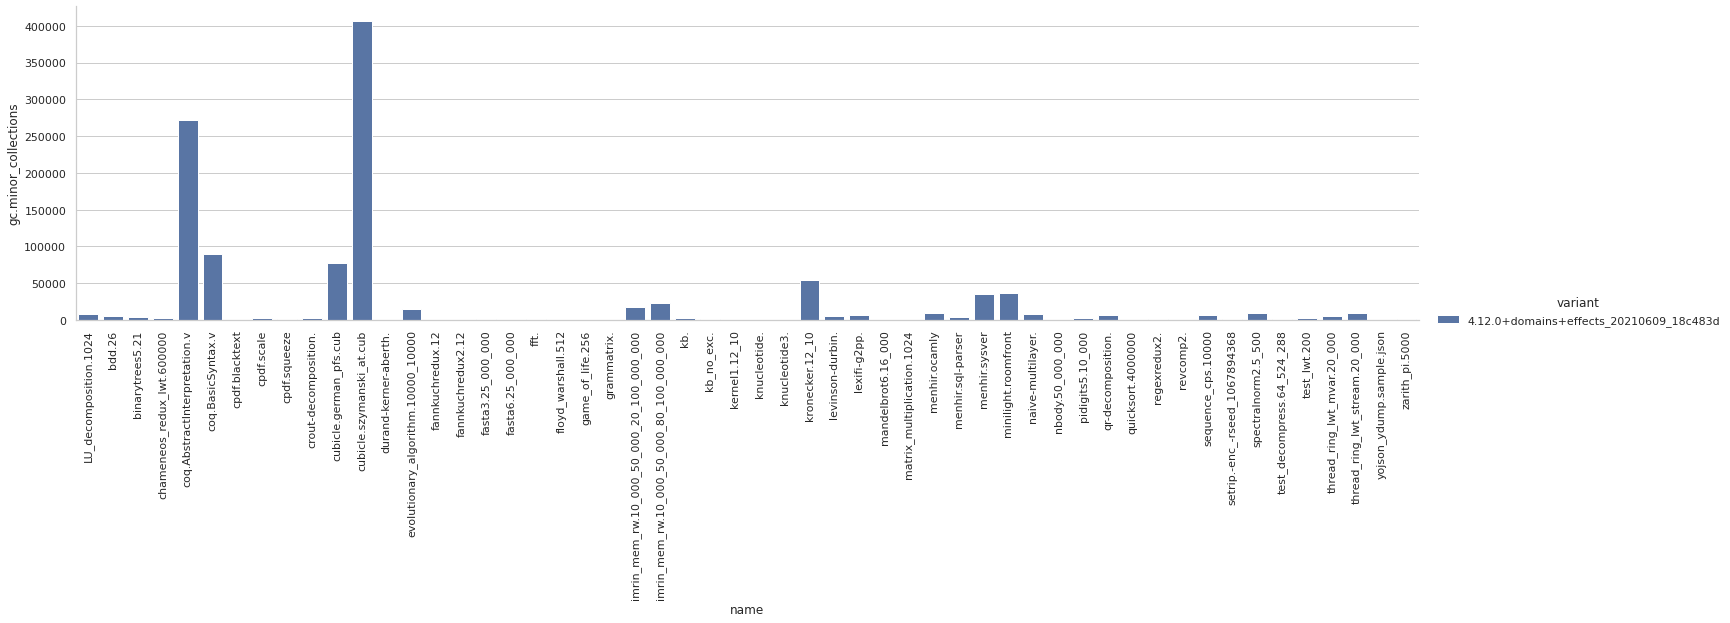

In [134]:
g = sns.catplot (x='name', y='gc.minor_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [135]:
ndf = normalise(df,selected_baseline,'gc.minor_collections')
plot_normalised(ndf,selected_baseline,'ngc.minor_collections')

The selected baseline variant is equal to the other variants
Update the dropdowns with different varians to plot normalisation graphs

ndf is equal to None, possibly due to variants being equal to the baseline variant



<ipython-input-124-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
